In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, nbinom, beta, poisson, gamma, norm, geom
from collections import namedtuple
import pandas as pd
import csv
import os
from pulp import LpMaximize, LpProblem, LpVariable, lpSum, LpBinary
import pulp
from itertools import islice

N_DAYS = 100
N_WORKERS = 10
MAX_PARTS = 10
SHORT_ENV = (100,42)
LONG_ENV = (3000,123)
benchmarks = {}
envs = {}
class Job:
    def __init__(self, name, reqs, parts, complication, soft_deadline, hard_deadline, payment):
        self.name = name
        self.n_workers = reqs
        self.parts = parts
        self.parts_completed = 0
        self.days_worked = 0
        self.days_passed = 0
        self.complication_probability = complication
        self.soft_deadline = soft_deadline
        self.hard_deadline = hard_deadline
        self.payment = payment
        self.final_payment = -1
        self.rate = self.return_rate()
        self._progression=create_job_progression(parts, complication)
        self.completed = False
        self.failed = False

    def __repr__(self):
        return f"{self.name}"
    def parts_remaining(self):
        return self.parts - self.parts_completed
    
    def soft_deadline_remaining(self):
        return self.soft_deadline - self.days_passed
    
    def hard_deadline_remaining(self):
        return self.hard_deadline - self.days_passed
    
    def payment_current(self):
        if self.hard_deadline_remaining() <= 0:
            return int(np.round(-0.2 * self.payment))
        elif self.soft_deadline_remaining() <= 0:
            n_days_past = np.abs(self.soft_deadline_remaining() - 1)
            return int(np.round((1 - 0.15*n_days_past) * self.payment))
        else:
            return self.payment 
        
    def expected_length(self, current=True):
        parts = self.parts if not current else self.parts_remaining()
        if parts == 0:
            return 0 
        return 1 + (parts-1)*self.complication_probability

    def upper_length(self, current=True):
        parts = self.parts if not current else self.parts_remaining()
        if parts == 0:
            return 0
        return int(1 + binom(parts-1,self.complication_probability).ppf(0.95))
        
    def lower_length(self, current=True):
        parts = self.parts if not current else self.parts_remaining()
        if parts == 0:
            return 0
        return int(1 + binom(parts-1,self.complication_probability).ppf(0.05))
        
    def return_rate(self, current=True, omniscient=False):
        parts = self.parts if not current else self.parts_remaining()
        payment = self.payment if not current else self.payment_current()
        if omniscient:
            worked = self.days_worked if current else 0
            length = len(self._progression) - worked
        else:
            length = self.expected_length(current)
        if parts == 0:
            return 0
        return payment / (self.n_workers * length)
    
    def advance_day(self):
        if not self.is_ended():
            self.days_passed += 1
        if self.hard_deadline_remaining() <= 0 and not self.completed:
            self.failed = True
            self.on_time = False
            self.final_payment = self.payment_current()

    def work(self):
        self.parts_completed += self._progression[self.days_worked]
        self.days_worked += 1
        if self.parts_remaining() == 0:
            self.completed = True
            self.on_time = self.soft_deadline_remaining() > 0
            self.final_payment = self.payment_current()
        
    def is_ended(self):
        return self.failed or self.completed
    
    def last_progress(self):
        if self.days_worked == 0:
            return 0
        else:
            return self._progression[self.days_worked - 1]
        
    def __str__(self):
        return (f'{self.name}: ' + 
                f'{self.n_workers} Workers, ' +
                f'{self.parts_completed}/{self.parts} Parts, ' + 
                f'{self.complication_probability*100:2.0f}%, ' + 
                f'{self.soft_deadline_remaining():2}/{self.hard_deadline_remaining():2} Deadlines, ' +
                f'{self.payment_current()} Cents')
    
    
def create_job_progression(parts, complication_prob):
    dist = geom(complication_prob)
    progression = []
    while parts > 0:
        day_progress = dist.rvs()
        parts -= day_progress
        if parts >= 0:
            progression.append(day_progress)
        else:
            progression.append(day_progress + parts)
    return progression


def create_random_job(name, threshold=1.3):
    name = name
    parts = MAX_PARTS
    
    req_diff = np.maximum(0,norm.rvs(loc=1.2,scale=0.2))
    n_workers = 1 + binom.rvs(n=9, p=0.18*req_diff)
    
    job_diff = np.maximum(0,norm.rvs(loc=1.4,scale=0.1))
    time_diff = beta.rvs(a=9.6,b=5.2)
    
    complication_probability = beta.rvs(a=1.7*job_diff, b=3.5)
    completion_dist = binom(parts-1,complication_probability)
    soft_deadline = int(min(2*MAX_PARTS, np.ceil((1+completion_dist.ppf(0.8))/time_diff)))
    hard_deadline = int(min(2*MAX_PARTS, np.ceil((1+completion_dist.ppf(0.8))/time_diff**1.8)))
    
    expected_length = 1 + (parts-1)*complication_probability
    expected_worker_days = expected_length*n_workers
    urgency = expected_length / soft_deadline
    slack_days = soft_deadline - expected_length
    
    mean_rate = 0.015
    urgency_cent = (urgency-0.45)/0.1
    workers_cent = (n_workers-3.0)/1.24
    length_cent = (expected_length-4.5)/1.7
    mean_payment_rate = mean_rate * np.exp(0.05*(req_diff-1.2)/0.15 + 
                                           0.05*(job_diff-1.4)/0.1 + 
                                           0.05*(time_diff-0.55)/0.15 + 
                                           0.15*workers_cent + 
                                           -0.10*length_cent + 
                                           0.22*urgency_cent + 
                                           -0.15*(slack_days-5.4)/2.6 + 
                                           -0.03*np.maximum(0,workers_cent)*np.maximum(0,length_cent) + 
                                           0.04*np.maximum(0,urgency_cent)*np.maximum(0,workers_cent) + 
                                           0.07*np.maximum(0,urgency_cent)*np.maximum(0,-length_cent) + 
                                           0.04*np.maximum(0,urgency_cent)*np.maximum(0,-length_cent)*np.maximum(0,workers_cent)
                                          )
    std = 0.01
    scale = std**2 / mean_payment_rate
    payment_rate = gamma.rvs(a=mean_payment_rate/scale, scale=scale)
    if payment_rate*100 < threshold:
        return create_random_job(name, threshold)
    payment = np.maximum(1,int(payment_rate*expected_worker_days*100))
    return Job(name, n_workers, parts, complication_probability, soft_deadline, hard_deadline, payment)


def jobs_str(jobs, progresses=False, status_name="Status", statuses=None, worked=None, current=True, omniscient=False):
    progresses = progresses or (worked is not None)
    header = ""
    if statuses:
        header += f"{status_name:<11}| "
    header += f"{'Name':<10} {'Workers':<10}"
    if progresses:
        header += f" {'Progress':<15}"
    header += f" {'Length':<20} {'Deadlines':<15} {'Payment':<15} {'Rate':<10}"
    if omniscient:
        header += f" {'Real Rate':<10}"
    output_str = header + '\n'
    
    if statuses:
        output_str += '-'*11 + '+-'
    output_str += '-'*21
    if progresses:
        output_str += '-'*16
    output_str += '-'*64
    if omniscient:
        output_str += '-'*11
    output_str += '\n'
    for job in jobs:
        if statuses:
            output_str += f"{statuses[job.name]:^11}| "
        name_str, res_str, payment_str, deadline_str, length_str, rate_str = common_job_str(job, current=current)
        output_str += f"{name_str:<10} {res_str:^10}"
        if progresses:
            if worked is None:
                perc_comp = job.parts_completed / job.parts * 100
                progress = f"{perc_comp:.0f}%"
            else:
                parts_completed_this_day = job.last_progress() * worked.setdefault(job.name, 0)
                progress = progress_str(job, parts_completed_this_day)
            output_str += f" {progress:<15}"
        output_str += f" {length_str:<20} {deadline_str:<15} {payment_str:<15} {rate_str:<10}"
        if omniscient:
            real_rate_str = f" {job.return_rate(current,omniscient):2.1f} Cents"
            output_str += f" {real_rate_str:<10}"
        output_str += '\n'
    return output_str


def progress_str(job, completed_this_day, include_zero=False):
    perc_comp = job.parts_completed / job.parts * 100
    added_perc_comp = completed_this_day / job.parts * 100
    out = f"{perc_comp:.0f}%"
    if include_zero or completed_this_day > 0:
        out += f" (+{added_perc_comp:.0f}%)"
    return out


def common_job_str(job, current=True):
    s_deadline = job.soft_deadline_remaining() if current else job.soft_deadline
    h_deadline = job.hard_deadline_remaining() if current else job.hard_deadline
    pay = job.payment_current() if current else job.payment
    if s_deadline <= 0:
        payment_str = f"${pay/100:.2f}(${job.payment/100:.2f})"
    else:
        payment_str = f"${pay/100:.2f}"
    deadline_str = f"{s_deadline:2}/{h_deadline} Days"
    length_str = f"{job.expected_length(current):2.1f} Days [{job.lower_length(current)}--{job.upper_length(current)}]"
    rate_str = f"{job.return_rate(current):2.1f} Cents"
    return (job.name,
            job.n_workers,
            payment_str,
            deadline_str,
            length_str,
            rate_str)


class DayHistory:
    def __init__(self, day, offers, offer_actions, jobs_before, job_actions):
        self.day = day
        self.offers = offers
        self.offer_actions = offer_actions
        self.jobs = jobs_before
        self.job_actions = job_actions
        self.ended = [job for job in jobs_before if job.is_ended()]
        self.ended_actions = [job_actions[i] for i in range(len(job_actions)) if self.jobs[i] in self.ended]
        self._n_workers_assigned = None
        self._utilization = None
        self._active_worker_rate = [None,None]
        self._worker_rate = [None, None]
        self._average_length = [None, None]
        self._average_workers = None
        self._expected_commitment = [None, None]
        self._value = None
        
    def get_taken_jobs(self):
        return [self.offers[i] for i in range(len(self.offers)) if self.offer_actions[i] == 1]
    
    def get_untaken_jobs(self):
        return [self.offers[i] for i in range(len(self.offers)) if self.offer_actions[i] != 1]
    
    def get_worked_jobs(self):
        return [self.jobs[i] for i in range(len(self.jobs)) if self.job_actions[i] == 1]
    
    def get_n_workers_assigned(self):
        if self._n_workers_assigned is None:
            self._n_workers_assigned = sum(job.n_workers for job in self.get_worked_jobs())
        return self._n_workers_assigned

    def get_utilization(self, n_workers=None):
        n = N_WORKERS if n_workers is None else n_workers
        return self.get_n_workers_assigned()/n

    def get_hindsight_worker_rate(self, n_workers=None):
        n = N_WORKERS if n_workers is None else n_workers
        tot_return = sum(max(0,job.final_payment) for job in self.get_worked_jobs())
        return tot_return/n
        
    def get_worker_rate(self, n_workers=None, current=False):
        if self._worker_rate[int(current)] is None:
            n = N_WORKERS if n_workers is None else n_workers
            tot_return = sum(job.n_workers*job.return_rate(current) for job in self.get_worked_jobs())
            self._worker_rate[int(current)] = tot_return/n
        return self._worker_rate[int(current)]

    def get_active_worker_rate(self, n_workers=None, current=False):
        n = N_WORKERS if n_workers is None else n_workers
        if self.get_n_workers_assigned() == 0:
            return 0
        return self.get_worker_rate(current)*n/self.get_n_workers_assigned()

    def get_average_length(self, current=True):
        if len(self.jobs) == 0:
            return 0
        if self._average_length[int(current)] is None:
            self._average_length[int(current)] = np.mean([job.expected_length(current) for job in self.jobs])
        return self._average_length[int(current)]

    def get_average_workers(self):
        if len(self.jobs) == 0:
            return 0
        if self._average_workers is None:
            self._average_workers = np.mean([job.n_workers for job in self.jobs])
        return self._average_workers

    def get_expected_commitment(self, current=True):
        if self._expected_commitment[int(current)] is None:
            self._expected_commitment[int(current)] = sum(job.expected_length(current)*job.n_workers for job in self.jobs)
        return self._expected_commitment[int(current)]

    def get_payment(self):
        if self._value is None:
            self._value = sum(job.final_payment for job in self.ended)
        return self._value

    
    def get_pretty_str(self, include_taken=False):
        outstr = ''
        outstr += self.get_offers_pretty_str()
        outstr += '\n\n'
        outstr += self.get_active_pretty_str(include_taken=include_taken)
        if self.ended:
            outstr += '\n\n'
            outstr += self.get_ended_pretty_str()
        outstr += '\n' + f"{self.get_n_workers_assigned()}/{N_WORKERS} Workers assigned.\n" 
        return outstr
        
    def get_offers_pretty_str(self, actions=True):
        out = 'Job Offers\n'
        if not actions:
            return out + jobs_str(self.offers)
        statuses = {}
        for i, job in enumerate(self.offers):
            if self.offer_actions[i] == 0:
                statuses[job.name] = ''
            elif self.offer_actions[i] == 1:
                statuses[job.name] = 'X'
            elif self.offer_actions[i] == -1:
                statuses[job.name] = 'Tried'
            else:
                statuses[job.name] = '?'
        return out + jobs_str(self.offers, status_name="Accepted?", statuses=statuses)

    def get_active_pretty_str(self, actions=True, include_ended=False, include_taken=False):
        out = 'Active Jobs\n'
        if include_ended:
            jobs_to_str = self.jobs
        else:
            jobs_to_str = [job for job in self.jobs if not job.is_ended()]
        if include_taken:
            jobs_to_str += self.get_taken_jobs()
        if not actions:
            return out + jobs_str(jobs_to_str)
            
        statuses = {}
        worked = {}
        for i, job in enumerate(self.jobs):
            if self.job_actions[i] == 1:
                statuses[job.name] = "X"
                worked[job.name] = 1
            elif self.job_actions[i] == -1:
                statuses[job.name] = "Tried"
                worked[job.name] = 0
            elif self.job_actions[i] == 0:
                statuses[job.name] = ""
                worked[job.name] = 0
            else:
                statuses[job.name] = "?"
                worked[job.name] = 0
        if include_taken:
            for job in self.get_taken_jobs():
                statuses[job.name] = "New"
                worked[job.name] = 0
            
        return out + jobs_str(jobs_to_str, status_name="Active?", statuses=statuses, worked=worked)

    def get_ended_pretty_str(self):
        if not self.ended:
            return ""
        output_str = 'Ended Jobs\n'
        header = f"{'Outcome':<10}| {'Name':<10} {'Workers':<10} {'Progress':<15} {'Deadlines':15} {'Payment':<20}\n"
        output_str += header
        output_str += '-'*10 + '+' + '-'*75 + '\n'
        for i,job in enumerate(self.ended):
            if job.completed:
                status = "Completed"
            elif job.failed:
                status = "Failed"
            else:
                status = "?"
            parts_completed_this_day = job.last_progress() * max(0,self.ended_actions[i])
            name_str, res_str, payment_str, deadline_str, length_str, rate_str = common_job_str(job)
            progress = progress_str(job, parts_completed_this_day)
            payment_str = f"${job.final_payment/100:.2f}"
            output_str += f"{status:<10}| {name_str:<10} {res_str:^10} {progress:<15} {deadline_str:<15} {payment_str:<20}\n"
        return output_str

        
def flatten(lsts):
    return [item for sublist in lsts for item in sublist]
    
class EnvHistory:
    def __init__(self, n_days=None, n_workers=None):
        self.history = []
        self.n_days = N_DAYS if n_days is None else n_days
        self.n_workers = N_WORKERS if n_workers is None else n_workers
        self._reset_cache()
        
    def _reset_cache(self):
        self._n_taken = None
        self._n_workers_assigned = None
        self._total_payments = None
        self._n_ended = None
        
    def record(self, day_hist):
        self.history.append(day_hist)
        self._reset_cache()

    def get_offered(self, flattened=False):
        lsts = [day_hist.offers for day_hist in self.history]
        return flatten(lsts) if flattened else lsts
        
    def get_taken(self, flattened=False):
        lsts = [day_hist.get_taken_jobs() for day_hist in self.history]
        return flatten(lsts) if flattened else lsts
    
    def get_untaken(self, flattened=False):
        lsts = [day_hist.get_untaken_jobs() for day_hist in self.history]
        return flatten(lsts) if flattened else lsts
    
    def get_ended(self, flattened=False):
        lsts = [day_hist.ended for day_hist in self.history]
        return flatten(lsts) if flattened else lsts
    
    def get_n_taken(self):
        if self._n_taken is None:
            self._n_taken = sum(len(day_taken) for day_taken in self.get_taken())
        return self._n_taken
    
    def get_n_ended(self):
        if self._n_ended is None:
            self._n_ended = sum(len(day_ended) for day_ended in self.get_ended())
        return self._n_ended
    
    def acceptance_rate(self):
        n_untaken = sum(len(day_untaken) for day_untaken in self.get_untaken())
        return self.get_n_taken() / (self.get_n_taken() + n_untaken)
    
    def completion_rate(self):
        n_completed = sum(job.completed for job in self.get_ended(flattened=True))
        return n_completed/self.get_n_ended()
    
    def on_time_rate(self):
        n_ontime = sum(job.on_time for job in self.get_ended(flattened=True))
        return n_ontime / self.get_n_ended()
    
    def avg_accepted_length(self):
        if self.get_n_taken == 0:
            return 0
        tot_lengths = sum(job.expected_length(current=False) for job in self.get_taken(flattened=True))
        return tot_lengths / self.get_n_taken()
        
    def avg_accepted_workers(self):
        if self.get_n_taken == 0:
            return 0
        tot_workers = sum(job.n_workers for job in self.get_taken(flattened=True))
        return tot_workers / self.get_n_taken()
        
    def avg_accepted_rate(self):
        if self.get_n_taken == 0:
            return 0
        tot_rates = sum(job.return_rate(current=False) for job in self.get_taken(flattened=True))
        return tot_rates / self.get_n_taken()
    
    def get_n_workers_assigned(self):
        if self._n_workers_assigned is None:
            self._n_workers_assigned = sum(day_hist.get_n_workers_assigned() for day_hist in self.history)
        return self._n_workers_assigned
        
    def utilization(self):
        return self.get_n_workers_assigned() / (self.n_workers*len(self.history))
    
    def total_payment(self, day=None):
        if self._total_payments is None:
            self._total_payments = np.cumsum([day_hist.get_payment() for day_hist in self.history])
        if not day:
            day = len(self._total_payments)
        return self._total_payments[day-1]
    
    def utilized_rate(self):
        return self.total_payment() / self.get_n_workers_assigned()
    
    def rate(self):
        return self.total_payment() / (self.n_workers*len(self.history))

    def get_pretty_str(self):
        out = ''
        for i, day_hist in enumerate(self.history):
            out += f'Day: {i+1}: Total Payment: ${self.total_payment(i+1)/100:.2f}\n'
            out += day_hist.get_pretty_str()
            out += '\n' + '-'*120
            out += '\n' + '-'*120 + '\n'
        return out
        
        
class JobEnv():
    def __init__(self, seed=None, n_days=None, n_workers=None, threshold=1.3, debt=0):
        self.n_days = n_days if n_days is not None else N_DAYS
        self.max_jobs = 20
        self.max_arrivals = 7
        self.n_workers = n_workers if n_workers is not None else N_WORKERS
        self.threshold = threshold
        self.jobs = []
        self.offers = []
        self.debt=debt
        
        n_obs_jobs = self.max_jobs + self.max_arrivals
        self.reset(seed)
        
        
    def reset(self, seed=None,job_list=None):
        if seed:
            np.random.seed(seed)
        self.total_payment = -self.debt
        self.current_day = 0
        self.jobs = []
        self.all_jobs = []
        self.history = EnvHistory(self.n_days, self.n_workers)
        if job_list:
            self.all_jobs=job_list
        else:
            for day in range(self.n_days):
                self.all_jobs.append(self.generate_jobs(day))
        self.offers = self.all_jobs[self.current_day]
        

    def soft_reset(self):
        self.total_payment = -self.debt
        self.current_day = 0
        self.jobs = []
        self.history = EnvHistory(self.n_days, self.n_workers)
    
    def step(self, job_acceptances, work_actions, record=True):
        if self.current_day >= self.n_days:
            return
        
        used = 0
        realized_actions = copy.copy(work_actions)
        active_jobs = self.jobs.copy() # Copy so removing jobs from self.jobs doesn't mess up iterating
        for i,job in enumerate(active_jobs):
            if work_actions[i] ==1:
                if used + job.n_workers <= self.n_workers:
                    used += job.n_workers
                    self.total_payment += self.process_job(job)
                else:
                    realized_actions[i] = -1
        self.total_payment += self.advance_day(active_jobs)
        
        realized_acceptances = copy.copy(job_acceptances)
        for i, job in enumerate(self.offers):
            if job_acceptances[i] == 1:
                if len(self.jobs) < self.max_jobs:
                    self.take_job(job)
                else:
                    realized_acceptances[i] = -1
        self.jobs.sort(key=lambda job: (job.hard_deadline_remaining()))
        
        if record:
            self.history.record(DayHistory(self.current_day, copy.deepcopy(self.offers), realized_acceptances, copy.deepcopy(active_jobs), realized_actions))
        if self.current_day < self.n_days:
            self.offers = self.all_jobs[self.current_day]
        else:
            self.offers = []

    def insufficient_workers(self, actions, active_jobs):
        used_reqs = 0
        for i,job in enumerate(active_jobs):
            if actions[i]==1:
                used_reqs += job.n_workers
        return used_reqs > self.n_workers
    
    
    def process_job(self, job) -> float:
        job.work()
        if job.completed:
            self.complete_job(job)
            return job.final_payment
        else:
            return 0

            
    def advance_day(self, active_jobs):
        incurred_penalties = 0
        self.current_day += 1
        for job in active_jobs:
            if not job.is_ended():
                job.advance_day()
            if job.failed:
                self.complete_job(job)
                incurred_penalties += job.final_payment
        return incurred_penalties
            
        
    def generate_jobs(self, day) -> list:
        jobs_arrived = min(poisson.rvs(mu=2), self.max_arrivals)
        return [create_random_job(f"{day+1}-{i}", self.threshold) for i in range(jobs_arrived)]
            
        
    def complete_job(self, job):
        job.final_payment = job.payment_current()
        self.jobs.remove(job)

        
    def take_job(self, job):
        self.jobs.append(job)
 

    def get_detailed_info(self):
        active_job_names = [job.name for job in self.jobs]
        return self.episode, self.current_day, self.n_workers, len(self.jobs), active_job_names
    

    def get_pretty_str(self, all_days=False):
        now_available_str = f'Day: {self.current_day+1}: Total Payment: ${self.total_payment/100:.2f}\n'
        if self.current_day < self.n_days:
            now_available_str += "Job Offers\n"
            now_available_str += jobs_str(self.offers)

        if all_days:
            out = self.history.get_pretty_str()
            out += '\n' + now_available_str
            if self.current_day > 0:
                hist = self.history.history[-1]
                out += '\n' + hist.get_active_pretty_str(include_taken=True)
        else:
            out = now_available_str
            if self.current_day > 0:
                hist = self.history.history[-1]
                out += (
                     '\n' + hist.get_active_pretty_str(include_taken=True) +
                     '\n' + hist.get_ended_pretty_str() +
                     '\n' + f"{hist.get_n_workers_assigned()}/{self.n_workers} Workers assigned.\n" +
                     '\n' + '-'*120 + 
                     '\n' + '-'*120 + '\n' + 
                     '\n' + hist.get_offers_pretty_str()
                     )
        return out
    
    
def pay_schedule(job):
    pays = []
    for days in range(1,job.hard_deadline + 10):
        if days > job.hard_deadline:
            pays.append(-int(0.2*job.payment))
        elif days > job.soft_deadline:
            pays.append(int((1 - 0.15*(days - job.soft_deadline))*job.payment))
        else:
            pays.append(job.payment)
    return pays


Strategy = namedtuple('Strategy', ['name','offer_strat','work_strat'])
FixedStrategy = namedtuple('FixedStrategy', ['name', 'seed','actions'])

kevin_actions_42 =[
    ([1,1,1,1],[]), ([1,0,1],[1,1,1,1]), ([],[0,1,0,1,1,1]), ([0,0],[0,1,0,1,1,1]),  ([1],[1,1,0,1,1]),
    ([0,0,1],[1,0,1,1]),  ([0],[0,1,0,1]), ([1],[0,1,0,1]), ([1,1,1],[0,0,1,1]), ([0,0],[0,1,1,0,0,0,1]),
    ([0,1,1,0],[0,1,0,1,1,1]), ([0,1,1],[0,1,1,0,1,1,0]), ([0],[0,1,1,0,0,0,0,1]), ([0],[0,1,0,1,0,1,0,1]),  ([],[0,1,1,0,1,0,0]),
    ([1,1],[0,0,0,1,1,1]), ([0,1],[0,1,1,1,0,0,1]), ([0],[0,1,1,1,0,0,1]), ([1,0],[0,1,1,0]), ([],[1,1,1,1]),
    ([0,1,1,0,1],[1,1,1]),  ([0,0],[0,1,1,1]), ([],[0,1,1,1]), ([0,1],[0,1,1,1]), ([1,1,1],[1,1,1]),
    ([0,0,1,1,0],[1,1,0,1,0,1]), ([0,0,1],[0,0,1,0,1,1,1]), ([0,0],[1,1,0,0,1,1]), ([1,0],[1,0,0,1,1,1]), ([0,0,1],[1,0,0,1,1,0,1]),
    ([0,0,1],[0,0,0,1,1,0,1]), ([],[0,0,0,1,1,0,1,0]), ([0,1,0,0],[1,0,1,0,1,0]), ([0,1,0],[1,0,1,0,1,0,0]), ([0,0,0,0],[0,0,0,1,1,0,0,0]),
    ([0],[0,0,0,1,1,0,0]), ([],[0,0,1,1,0,0]), ([0,1,0,0],[1,1,1,0]), ([0,0],[1,1,1,0,0]), ([],[1,0,1,1,0]),
    ([0,1,1],[1,1,0,1]), ([0,0,1,1],[1,1,0,0,1,1]), ([1,0,0,0],[0,0,1,1,1,1]), ([0,0],[0,1,1,0,0,1]), ([0,0,1,0],[0,1,1,0,1,0]),
    ([],[0,0,1,1,1,0,0]), ([1],[0,0,1,1,0,1,0]), ([0],[0,0,0,1,1,0,1]), ([],[0,0,1,1,0,1]), ([0,0,0],[1,1,1,0,0,1]),
    ([0,1],[0,1,1]), ([0],[0,1,1,0]), ([1],[1,1,1]), ([1,1],[1,1,1]), ([0],[1,1,1]),
    ([1,1],[1,1,1]), ([1,0,0],[1,0,1,0,1]), ([0,1],[1,1,1,0,1]), ([1,0],[1,1,1,1,0]), ([],[1,1,1,1,0,0]),
    ([1,0,0],[1,1,1,0,0]), ([],[1,1,0,0,1]), ([0],[0,1,1]), ([],[0,1,1]), ([0,0],[0,1,1]),
    ([],[0,1,1]), ([0,0,1,0],[0,1,1]), ([1],[0,1,1,0]), ([1],[0,1,0,1,0]), ([0,1],[0,1,0,0,1,1]),
    ([0,1],[0,1,0,0,1,1,1]), ([0,0],[0,1,1,1,1,1,0]), ([],[1,1,1,1,1]), ([0,1,0,1],[1,1,1,1]), ([1],[1,1,1,0]),
    ([1,0],[1,1,1]), ([1,1],[1,1,1,0]), ([1],[1,1,1,1,0]), ([1,1,1],[0,1,1,1,1]), ([1],[1,1,1,0,1,0,0,1]),
    ([1,0],[1,1,1,0,0,1,0,1,0]), ([0,0],[0,1,0,0,0,1,1,0,1]), ([0,1,0,0],[0,1,0,0,0,1,1,1,0]), ([0,0],[1,0,0,0,1,1,1,0,0,0]), ([1],[0,0,0,0,1,1,1,0]),
    ([0,0,0,1,0],[1,1,0,0,1,0,1,0,0]), ([0,0,1,0],[0,0,1,1,1,0,0,0]), ([0,0,0,0,0,0],[0,0,1,1,0,0,1,0]), ([0,0],[0,0,0,1,0,0,0,1]), ([1,0,0],[0,0,1,1,1,1]),
    ([0,0],[0,0,1,1,1]), ([0,0,0],[0,0,1,1,1]),  ([1],[0,0,1,1,1]), ([],[0,1,1,1,0]), ([1,0,1],[0,1,1,1,0]),
    ([0],[0,0,0,1,0,1,1]), ([1],[0,1,0,1]), ([1],[1,1,1]), ([1],[1,1,1]), ([0,1],[1,1,1]),
]
kevin_strat = FixedStrategy(name='Kevin', seed=42, actions=kevin_actions_42)
opt_actions_42 = [([1,1,0,1], []), ([1,0,1], [1,1,1]), ([], [1,1,1,0,1]), ([1,0], [1,0,1,1]), ([0], [0,1,0,1,1]),
                  ([0,1,0], [0,1,0,1,1]), ([1], [1,0,1,0,1]), ([1], [1,0,0,1,0,1]), ([0,1,1], [1,1,0,1,0]), ([0,1], [0,1,1,1,0]),
                  ([0,1,0,1], [0,1,1,1,0,0]), ([0,1,1], [0,1,0,1,0,0,0,1]), ([1], [0,1,1,0,0,0,0,0,1]), ([0], [1,0,0,1,0,0,0,1,0,0]), ([], [0,0,0,1,1,0,1,0,0]),
                  ([1,1], [1,0,1,0,0,1,0]), ([0,1], [0,0,1,1,1,0,0]), ([1], [0,0,1,1,1,0,0,0]), ([0,0], [0,1,0,0,0,1,1]), ([], [1,1,0,0,1]),
                  ([0,0,1,1,0], [1,1,0,0,1]), ([0,0], [0,0,1,1,1]), ([], [1,1,0,1,0]), ([0,0], [1,1,0,1]), ([1,1,0], [1,1,1]),
                  ([1,0,1,1,0], [1,1,0,1]), ([0,0,1], [0,1,0,1,0,1,1]), ([0,0], [0,1,1,1,1,0]), ([0,0], [0,1,1,1,1,0]), ([0,0,1], [1,1,1,1,0]),
                  ([0,0,1], [0,1,1,1]), ([], [1,1,1,0,1]), ([0,1,1,1], [1,0,1,1]), ([0,0,1], [0,1,0,1,1,0]), ([0,0,0,0], [1,1,1,0,0,1,0]),
                  ([0], [1,1,1,0,0,0,0]), ([], [0,0,1,1,1]), ([0,1,0,1], [1,1,1,0,0]), ([0,1], [1,1,1,0,0,0,0]), ([], [0,1,1,1,0,0,0]),
                  ([0,0,1], [0,1,1,1,0,0,0]), ([0,1,1,0], [1,0,1,0,0,0,1]), ([0,0,1,0], [0,1,1,1,0,0,0,0,0]), ([0,0], [1,1,1,0,0,0,0,0,0,0]), ([0,0,0,0], [1,0,1,0,0,0,0,0]),
                  ([], [0,1,1,0,0,1,0]), ([1], [1,0,1,1,0,1,0]), ([1], [0,1,0,1,0,1]), ([], [1,0,1,1,0,1,0]), ([1,0,1], [1,1,1,0,0,0]),
                  ([1,1], [1,1,0,1,0,1,0]), ([0], [1,0,1,0,0,0,1]), ([1], [1,1,0,0,1,0]), ([0,1], [0,1,1,1,0,0,0]), ([0], [0,1,0,1,0,0,1]),
                  ([1,0], [1,1,0,0,1,1]), ([1,0,0], [0,1,1,0,1]), ([0,1], [1,1,1,0,0,0]), ([0,0], [1,0,0,1,1,1]), ([], [1,1,0,0,1]),
                  ([1,0,1], [1,1,1,0,0]), ([], [1,0,0,1,0,1]), ([0], [1,0,0,0,1,1]), ([], [1,1,1,1,0]), ([1,1], [1,1,1,1,0]),
                  ([], [1,1,1,0,1,0]), ([0,0,1,0], [1,1,1,0,0]), ([1], [0,1,0,1,1,1]), ([1], [1,0,1,0,0,1,1]), ([1,1], [1,1,0,1,1,1]),
                  ([1,1], [1,1,1,0,0,1,0]), ([0,0], [0,1,1,1,0,1,1]), ([], [0,1,0,1,1,1,1]), ([0,0,1,1], [1,1,0,1,1,0,1]), ([1], [1,1,1,1,1]),
                  ([1,1], [1,0,1,0,1,1]), ([1,0], [0,1,1,1,1,0]), ([1], [0,1,0,1,1,1]), ([0,0,1], [1,1,1,1,1,0]), ([1], [1,0,0,1,1,1]),
                  ([1,0], [0,0,1,1,0,1]), ([0,0], [1,0,0,0,0,1,1]), ([0,0,0,0], [0,0,1,1,0,0,1]), ([1,0], [0,1,1,1,1]), ([1], [1,1,0,1,1]),
                  ([0,0,1,1,0], [1,1,1,1]), ([0,0,1,0], [1,1,0,0,1,1]), ([0,1,1,0,0,0], [0,0,0,1,1]), ([1,1], [0,0,1,1,1,0]), ([0,1,0], [0,0,0,0,1,0,0,1]),
                  ([1,0], [1,0,0,0,0,1,0,1]), ([1,1,0], [1,0,0,1,0,1,0]), ([1], [1,1,1,0,0,1,0,0,0]), ([], [1,0,1,0,1,1,0,0,0,0]), ([1,0,1], [1,1,1,0,0,0,0,0]),
                  ([0], [1,0,0,1,1,0,0,0]), ([0], [1,1,1,1,0,0,0,0]), ([0], [1,1,1,1,0,1,0]), ([0], [1,1,1,0]), ([0,0], [1,1])]
opt_strat = FixedStrategy(name='Omniscient', seed=42, actions=opt_actions_42)

def get_env(n_days, seed):
    key = (n_days, seed)
    if key not in envs:
        envs[key] = JobEnv(n_days=n_days, seed=seed)
    return copy.deepcopy(envs[key])
    

def run_fixed_strategy(fixed_strat, n_days=None):
    n_days = max(SHORT_ENV[0], len(fixed_strat.actions)) if n_days is None else n_days
    env = get_env(n_days, fixed_strat.seed)
    actions = fixed_strat.actions
    while env.current_day < len(actions):
        acceptances, work = actions[env.current_day]
        env.step(acceptances, work)
    return env

def run_strategy(strategy, n_days=None, seed=None):
    n_days = LONG_ENV[0] if n_days is None else n_days
    seed = LONG_ENV[1] if seed is None else seed
    env = get_env(n_days,seed)
    offer_strat, work_strat = strategy.offer_strat, strategy.work_strat
    for _ in range(env.n_days):
        acceptances, work = offer_strat(env.offers, env), work_strat(env.jobs, env)
        env.step(acceptances, work)
    return env

def get_benchmarks(n_days, seed):
    return {}

def split_string_on_words(string, max_width):
    """Split a string into lines, splitting at word boundaries with a max line width."""
    words = string.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line) + len(word) + 1 <= max_width or not current_line:
            current_line += (" " + word) if current_line else word
        else:
            lines.append(current_line)
            current_line = word
    if current_line:
        lines.append(current_line)
    return lines

def get_comparison_table(envs, include_payments=False, max_column_width=11):
    metrics = [ "Strategy", 
        "Acceptance Rate", "Completion Rate", "On Time Rate",
        "Average Accepted Length", "Average Accepted Workers",
        "Average Accepted Rate", "Worker Utilization", "Utilized Rate",
        "Rate"
    ]
    if include_payments:
        metrics.append("Payments")

    split_metrics = [split_string_on_words(metric, max_column_width) for metric in metrics]
    max_lines = max(len(metric_lines) for metric_lines in split_metrics)
    padded_metrics = [[''] * (max_lines - len(lines)) + lines for lines in split_metrics]

    # Center-align each line within each metric
    aligned_metrics = [[line.center(max_column_width) for line in metric] for metric in padded_metrics]

    # Create the header
    header_lines = [' | '.join(metric[i] for metric in aligned_metrics) for i in range(max_lines)]
    header = "\n".join(header_lines) + "\n"
    separator = "-" * len(header_lines[0]) + "\n"

    # Start building the table
    outstr = header + separator

    sorted_envs = sorted(envs.items(), key=lambda item: item[1].history.rate(), reverse=True)
    # Add each environment's data
    for name, env in sorted_envs:
        row = name.ljust(max_column_width) + " | "
        hist = env.history
        metrics_data = [
            str(np.round(hist.acceptance_rate()*100,1))+"%",
            str(np.round(hist.completion_rate()*100,1))+"%",
            str(np.round(hist.on_time_rate()*100,1))+"%",
            str(np.round(hist.avg_accepted_length(),1))+" Days",
            str(np.round(hist.avg_accepted_workers(),1)),
            str(np.round(hist.avg_accepted_rate(),1))+ " Cents",
            str(np.round(hist.utilization()*100,1))+"%",
            str(np.round(hist.utilized_rate(),1))+" Cents",
            str(np.round(hist.rate(),2))+" Cents"
        ]
        if include_payments:
            metrics_data.append("$"+str(np.round(env.total_payment/100,2)))

        row += " | ".join(data.center(max_column_width) for data in metrics_data)
        outstr += row + "\n"
    return outstr

def moving_average(data, window_size):
    return pd.Series(data).rolling(window=window_size).mean()

    
def plot_cumulative_payment(envs, ax):
    for name, env in envs.items():
        payments = [env.history.total_payment(day=i) for i in range(1,len(env.history.history)+1)]
        ax.plot(payments, label=name)
    ax.set_title('Cumulative Payment')
    ax.set_xlabel('Periods')
    ax.legend()

def plot_moving_average(envs, day_hist_func, title, ax, window_size=5):
    for name, env in envs.items():
        metric_values = [day_hist_func(day_hist) for day_hist in env.history.history]
        ma_values = moving_average(metric_values, window_size)
        ax.plot(ma_values, label=name)
    ax.set_xlabel('Periods')
    ax.set_title(title)
    ax.legend()

def plot_all_combined(envs, window_size=5):
    # Set up the figure and axes
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    # Plot on the specific axes
    plot_cumulative_payment(envs, axes[0,0])
    plot_moving_average(envs, lambda dh: sum(job.n_workers for job in dh.jobs), "Total Workers Wanted", axes[0,1], window_size)
    plot_moving_average(envs, lambda dh: len(dh.jobs), "Number of Jobs", axes[0,2], window_size)
    plot_moving_average(envs, lambda dh: dh.get_expected_commitment(), "Committed WorkerDays (Expected)", axes[1,0], window_size)
    plot_moving_average(envs, lambda dh: dh.get_utilization(), "Worker Utilization", axes[1,1], window_size)
    plot_moving_average(envs, lambda dh: dh.get_hindsight_worker_rate(), "Realized Worker Productivity", axes[1,2], window_size*2)

    plt.tight_layout()
    return fig

def get_strategy_comparisons(strategies=None, fixed_strategies=None, benchmarks=True, window_size=5):
    long_envs = {}
    outstr = ""
    if strategies is None:
        strategies = []
    if fixed_strategies is None:
        fixed_strategies = []
    if benchmarks:
        long_envs.update(get_benchmarks(n_days=LONG_ENV[0], seed=LONG_ENV[1]))
    for strat in strategies:
        long_envs[strat.name] = run_strategy(strat, n_days=LONG_ENV[0], seed=LONG_ENV[1])
    if len(long_envs) > 0:
        outstr = "Long-run Comparisons:\n"
        outstr += get_comparison_table(long_envs)
    short_envs = {}
    if benchmarks:
        short_envs.update(get_benchmarks(n_days=SHORT_ENV[0], seed=SHORT_ENV[1]))
        fixed_strategies.append(kevin_strat)
    for strat in strategies:
        short_envs[strat.name] = run_strategy(strat, n_days=SHORT_ENV[0], seed=SHORT_ENV[1])
    for strat in fixed_strategies:
        if strat.seed == SHORT_ENV[1] and len(strat.actions) >= SHORT_ENV[0]:
            short_envs[strat.name] = run_fixed_strategy(strat, n_days=SHORT_ENV[0])
    if len(short_envs) > 0:
        outstr += '\n\nExperiment Parameters Comparisons:\n'
        outstr += get_comparison_table(short_envs, include_payments=True) 
    plots = plot_all_combined(short_envs, window_size)
    return outstr, plots
        

def fitness(offer_strat, work_strat, n_days=None, seed=None):
    n_days = LONG_ENV[0] if n_days is None else n_days
    seed = LONG_ENV[1] if seed is None else seed
    env = get_env(n_days,seed)
    for _ in range(env.n_days):
        acceptances, work = offer_strat(env.offers, env), work_strat(env.jobs, env)
        env.step(acceptances, work, record=False)
    return env.total_payment / (env.n_days * env.n_workers)

def write_csvs(name, strategies, n_days=None, seed=None):
    n_days = SHORT_ENV[0] if n_days is None else n_days
    seed = SHORT_ENV[1] if seed is None else seed
    job_filename = f'{name}_jobs.csv'
    env = get_env(n_days,seed)
    write_job_csv(job_filename, env)
    res_envs = []
    for strat in strategies:
        res_envs.append(run_strategy(strat, n_days=n_days, seed=seed))
    actions_filename = f'{name}_actions.csv'
    write_actions_csv(actions_filename, res_envs)
    summary_filename = f'{name}_summary.csv'
    write_day_histories_summary(summary_filename, res_envs)
    strats_filename = f'{name}_strategies.csv'
    with open(strats_filename, 'w', newline='') as file:
        writer = csv.writer(file)
        headers = ['sid', 'Strategy']
        writer.writerow(headers)
        for sid, strat in enumerate(strategies):
            writer.writerow([sid, strat.name])
    
def write_actions_csv(filename, res_envs):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)

        # Write the header
        headers = ['SubjectID', 'Day', 'Job Name', 'Action Type', 'Accepted/Worked On', 
                   'Parts Completed', 'Soft Deadline Remaining', 'Hard Deadline Remaining', 
                   'Current Payment', 'Payment Received']
        writer.writerow(headers)

        for sid, env in enumerate(res_envs):
            for day_hist in env.history.history:
                day = day_hist.day

                # Offer actions
                for offer, action in zip(day_hist.offers, day_hist.offer_actions):
                    writer.writerow([sid, day, offer.name, 'Offer', action, '', '', '', '', ''])

                # Job actions
                for job, action in zip(day_hist.jobs, day_hist.job_actions):
                    parts_completed = job.parts_completed
                    soft_deadline_remaining = job.soft_deadline_remaining()
                    hard_deadline_remaining = job.hard_deadline_remaining()
                    current_payment = job.payment_current()
                    payment = job.final_payment if job.is_ended() else ''
                    writer.writerow([sid, day, job.name, 'Work', action, parts_completed, 
                                     soft_deadline_remaining, hard_deadline_remaining, 
                                     current_payment, payment])

def write_job_csv(filename, env):
    # Open the file in write mode
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)

        # Write the header
        headers = ['Name', 'Day', 'Workers', 'Parts', 'Complication Probability', 
                   'Soft Deadline', 'Hard Deadline', 'Payment', 'ReductionRate', 'Penalty', 'Progression']
        writer.writerow(headers)

        # Write job data
        for day, job_list in enumerate(env.all_jobs):
            for job in job_list:
                progression_str = ','.join(map(str, job._progression))
                writer.writerow([
                    job.name, day+1,job.n_workers, job.parts, np.round(job.complication_probability,3),
                    job.soft_deadline, job.hard_deadline, job.payment, 0.85, int(np.round(-0.2 * job.payment)), progression_str
                ])
                
def write_day_histories_summary(filename, res_envs):
    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)

        # Write the header
        headers = ['sid', 'Day', 'Job Count', 'Workers Assigned', 'Utilization', 'Worker Rate', 'Active Worker Rate',
                   'Average Length', 'Average Workers', 'Expected Commitment', 'Payment']
        writer.writerow(headers)

        for sid, env in enumerate(res_envs):
            for day_hist in env.history.history:
                writer.writerow([
                    sid,
                    day_hist.day,
                    len(day_hist.jobs),
                    day_hist.get_n_workers_assigned(),
                    np.round(day_hist.get_utilization(),3),
                    np.round(day_hist.get_worker_rate(),2),
                    np.round(day_hist.get_active_worker_rate(),2),
                    np.round(day_hist.get_average_length(),1),
                    np.round(day_hist.get_average_workers(),1),
                    np.round(day_hist.get_expected_commitment(),1),
                    day_hist.get_payment()
                ])

def string_to_int_list(s):
    return list(map(int,s.split(',')))



In [12]:
treatment_folders = ['baseline_s1','baseline_s2','nowork_s1','nowork_s2','noaccept_s1','noaccept_s2','noaccept_s3']
day_folders = ['Day1', 'Day2']
treatment_index = 1
day_index = 0
subject = 6

# Function to get DataFrames from a specific treatment and day
def get_dataframes(treatment_folder, day_folder):

    folder_path = os.path.join(treatment_folder, day_folder)
    
    # Initialize a list to store the DataFrames
    dataframes = []
    print(os.listdir(folder_path))

    # Traverse the folder and read the xlsx files
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            dataframes.append(df)
    
    return dataframes

def process_treatment_file(treatment_folder):
    

    # Find the only .xlsx file in the treatment folder
    file_path = None
    for file_name in os.listdir(treatment_folder):
        if file_name.endswith('.xlsx'):
            file_path = os.path.join(treatment_folder, file_name)
            break
    
    if file_path is None:
        raise FileNotFoundError(f"No .xlsx file found in {treatment_folder}")
    
    # Read the Excel file into a DataFrame
    df = pd.read_excel(file_path)

    # Add 'LAB' before each number in the columns 'id_day1' and 'id_day2'
    df['id_day1'] = df['id_day1'].apply(lambda x: f'LAB{x}')
    df['id_day2'] = df['id_day2'].apply(lambda x: f'LAB{x}')
    
    return df


d1_invest,d1_time,d1_summary,d1_survey = get_dataframes(treatment_folders[treatment_index], day_folders[0])
d2_invest,d2_time,d2_summary,d2_survey = get_dataframes(treatment_folders[treatment_index], day_folders[1])
invest_data=[d1_invest,d2_invest]
time_data=[d1_time,d2_time]
summary_data=[d1_summary,d2_summary]
survey_data=[d1_survey,d2_survey]
ids = process_treatment_file(treatment_folders[treatment_index])

['baseline_s2_day1_investment_2024-05-06.csv', 'baseline_s2_day1_PageTimes-2024-05-06.csv', 'baseline_s2_day1_summary_2024-05-06.csv', 'baseline_s2_day1_survey_2024-05-06.csv']
['baseline_s2_day2_investment_2024-05-08.csv', 'baseline_s2_day2_PageTimes-2024-05-08.csv', 'baseline_s2_day2_summary_2024-05-08.csv', 'baseline_s2_day2_survey_2024-05-08.csv']


In [3]:
def get_participant_jobs(day_index,subject):
    df=invest_data[day_index]
    participant_accepts = df.loc[(df['Action Type']=='Offer')& (df['SubjectID']==subject) & (df['Accepted/Worked On']==1)]
    student_jobs=list(participant_accepts['Job Name'])
    return student_jobs

In [52]:
def get_participant_works(day_index,subject):
    df=invest_data[day_index]
    participant_works = df.loc[(df['Action Type']=='Work')& (df['SubjectID']==subject)]
    student_jobs=participant_works[['Day','Job Name','Accepted/Worked On']]
    return student_jobs

In [53]:
test_accept=get_participant_jobs(0,6)
test_works=get_participant_works(0,6)

In [6]:
def organize_participant_jobs(accepted_jobs):
    jobs=[[] for _ in range(N_DAYS)]
    with open('./exp_jobs.csv',mode='r') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            progression = string_to_int_list(row['Progression'])
            job = Job(name=row['Name'],
                    parts=MAX_PARTS,
                    reqs=int(row['Workers']),
                    complication=float(row['Complication Probability']),
                    soft_deadline=int(row['Soft Deadline']),
                    hard_deadline=int(row['Hard Deadline']),
                    payment=int(row['Payment'])
    )
            job._progression=progression
            day = int(row['Day'])
            #jobs[day-1].append(job)
            if job.name in accepted_jobs:
                jobs[day-1].append(job)
    return jobs

In [46]:
def experiment_jobs():
    jobs=[]
    with open('./exp_jobs.csv',mode='r') as file:
        csv_reader = csv.DictReader(file)
        for row in csv_reader:
            progression = string_to_int_list(row['Progression'])
            job = Job(name=row['Name'],
                    parts=MAX_PARTS,
                    reqs=int(row['Workers']),
                    complication=float(row['Complication Probability']),
                    soft_deadline=int(row['Soft Deadline']),
                    hard_deadline=int(row['Hard Deadline']),
                    payment=int(row['Payment'])
    )
            job._progression=progression
            day = int(row['Day'])
            jobs.append(job)
    return jobs

In [14]:
test_jobs=organize_participant_jobs(test_accept)

In [30]:
test_jobs_2=organize_participant_jobs(get_participant_jobs(1,23))

In [15]:
test_jobs

[[1-1, 1-2, 1-3],
 [2-0, 2-2],
 [],
 [4-1],
 [],
 [],
 [],
 [8-0],
 [9-0, 9-1, 9-2],
 [],
 [],
 [12-2],
 [13-0],
 [14-0],
 [],
 [16-1],
 [17-0, 17-1],
 [18-0],
 [19-0, 19-1],
 [],
 [21-1, 21-2, 21-4],
 [],
 [],
 [24-1],
 [25-0, 25-2],
 [26-2, 26-3],
 [],
 [],
 [],
 [30-2],
 [31-2],
 [],
 [33-1],
 [34-2],
 [],
 [],
 [],
 [38-3],
 [],
 [],
 [41-1, 41-2],
 [42-2],
 [],
 [44-1],
 [45-1],
 [],
 [47-0],
 [],
 [],
 [50-2],
 [51-1],
 [],
 [53-0],
 [54-0, 54-1],
 [55-0],
 [56-0],
 [57-0],
 [58-1],
 [59-0],
 [],
 [61-0],
 [],
 [],
 [],
 [],
 [],
 [67-2],
 [],
 [69-0],
 [70-1],
 [71-1],
 [],
 [],
 [74-1, 74-3],
 [75-0],
 [76-0],
 [77-0],
 [78-0],
 [79-2],
 [80-0],
 [81-0],
 [82-1],
 [83-1],
 [],
 [85-0],
 [86-3],
 [87-2],
 [],
 [89-1],
 [],
 [91-1],
 [],
 [93-0],
 [],
 [],
 [],
 [97-0],
 [],
 [99-0],
 [100-1]]

In [31]:
test_jobs_2

[[1-1, 1-3],
 [2-0, 2-2],
 [],
 [],
 [5-0],
 [6-2],
 [7-0],
 [8-0],
 [],
 [],
 [11-1],
 [],
 [13-0],
 [14-0],
 [],
 [16-0, 16-1],
 [],
 [18-0],
 [19-0, 19-1],
 [],
 [21-1],
 [],
 [],
 [24-1],
 [25-0, 25-1],
 [26-3],
 [27-2],
 [],
 [29-1],
 [],
 [31-2],
 [],
 [33-1, 33-3],
 [34-2],
 [],
 [36-0],
 [],
 [],
 [],
 [],
 [],
 [42-2],
 [],
 [],
 [],
 [],
 [47-0],
 [],
 [],
 [50-1],
 [],
 [52-0],
 [53-0],
 [54-1],
 [],
 [56-1],
 [57-0],
 [58-1],
 [59-0],
 [],
 [61-0],
 [],
 [],
 [],
 [],
 [],
 [67-2],
 [68-0],
 [],
 [70-1],
 [71-1],
 [],
 [],
 [74-1, 74-3],
 [],
 [76-0],
 [77-0, 77-1],
 [],
 [79-1],
 [],
 [81-0],
 [82-1],
 [],
 [84-0],
 [],
 [86-2, 86-3],
 [87-2],
 [88-1, 88-2],
 [],
 [90-0],
 [],
 [],
 [],
 [],
 [95-0],
 [],
 [97-0],
 [],
 [99-0],
 [100-1]]

In [38]:
def calculate_metrics(correct_list, incorrect_list):
    # Initialize lists to store results for each day
    TP = []
    FP = []
    FN = []
    day_percentages = []

    # Iterate through each day
    for correct_projects, incorrect_projects in zip(correct_list, incorrect_list):
        
        # Convert lists to sets for easier comparison
        correct_set = set([project.name for project in correct_projects])
        incorrect_set = set([project.name for project in incorrect_projects])


        # Calculate true positives, false positives, and false negatives
        true_positives = len(correct_set.intersection(incorrect_set))
        false_positives = len(incorrect_set - correct_set)
        false_negatives = len(correct_set - incorrect_set)

        correctly_handled_empty = 0  # Default to 0
        if not correct_projects and not incorrect_projects:
            # Both lists are empty, treat as correct decision
            correctly_handled_empty = 1
            TP.append(true_positives + correctly_handled_empty)
            FP.append(0)
            FN.append(0)
        elif not correct_projects and incorrect_projects:
            # Correct list is empty but incorrect has projects
            TP.append(0)
            FP.append(len(incorrect_projects))
            FN.append(0)
        elif correct_projects and not incorrect_projects:
            # Correct list has projects but incorrect is empty
            TP.append(0)
            FP.append(0)
            FN.append(len(correct_projects))
        else:
            # Normal case with non-empty lists
            TP.append(true_positives)
            FP.append(false_positives)
            FN.append(false_negatives)

        # Calculate day percentage
        total_projects = true_positives + false_positives + false_negatives
        if total_projects == 0:
            day_percentage = 100.0
        else:
            day_percentage = (true_positives + correctly_handled_empty) / total_projects * 100

        day_percentages.append(day_percentage)

    return TP, FP, FN, day_percentages

In [36]:
results=calculate_metrics(test_jobs,test_jobs_2)

In [39]:
results

([2,
  2,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  2,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  1,
  1,
  1,
  1,
  2,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  1],
 [0,
  0,
  0,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  2,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0]

In [54]:
exp_jobs=experiment_jobs()
work_req_dict = {project.name: project.n_workers for project in exp_jobs}
work_req_dict

{'1-0': 2,
 '1-1': 2,
 '1-2': 4,
 '1-3': 1,
 '2-0': 2,
 '2-1': 2,
 '2-2': 5,
 '4-0': 4,
 '4-1': 4,
 '5-0': 2,
 '6-0': 1,
 '6-1': 3,
 '6-2': 5,
 '7-0': 4,
 '8-0': 5,
 '9-0': 2,
 '9-1': 2,
 '9-2': 2,
 '10-0': 3,
 '10-1': 5,
 '11-0': 3,
 '11-1': 1,
 '11-2': 3,
 '11-3': 5,
 '12-0': 3,
 '12-1': 4,
 '12-2': 3,
 '13-0': 3,
 '14-0': 2,
 '16-0': 6,
 '16-1': 2,
 '17-0': 1,
 '17-1': 1,
 '18-0': 4,
 '19-0': 2,
 '19-1': 3,
 '21-0': 3,
 '21-1': 3,
 '21-2': 2,
 '21-3': 4,
 '21-4': 4,
 '22-0': 2,
 '22-1': 3,
 '24-0': 4,
 '24-1': 3,
 '25-0': 4,
 '25-1': 4,
 '25-2': 2,
 '26-0': 1,
 '26-1': 2,
 '26-2': 3,
 '26-3': 1,
 '26-4': 4,
 '27-0': 4,
 '27-1': 2,
 '27-2': 4,
 '28-0': 4,
 '28-1': 3,
 '29-0': 5,
 '29-1': 2,
 '30-0': 2,
 '30-1': 4,
 '30-2': 5,
 '31-0': 5,
 '31-1': 2,
 '31-2': 4,
 '33-0': 4,
 '33-1': 3,
 '33-2': 3,
 '33-3': 1,
 '34-0': 4,
 '34-1': 4,
 '34-2': 6,
 '35-0': 3,
 '35-1': 2,
 '35-2': 3,
 '35-3': 4,
 '36-0': 7,
 '38-0': 1,
 '38-1': 3,
 '38-2': 6,
 '38-3': 4,
 '39-0': 4,
 '39-1': 4,
 '41-0': 4

In [55]:
test_works

,Day,Job Name,Accepted/Worked On
125,2,1-1,1
126,2,1-2,1
127,2,1-3,1
239,3,1-1,0
240,3,1-2,0
...,...,...,...
12866,98,97-0,1
12931,99,86-3,1
12932,99,97-0,1
13000,100,97-0,1


In [56]:
def calculate_worker_sums(df, projects_projects):
    # Initialize lists to store results
    day_worker_sums = []

    # Iterate over days 1-100
    for day in range(1, 101):
        # Filter the rows for the current day
        day_data = df[df['Day'] == day]
        
        # Separate jobs based on 'Accepted/Worked On' column
        accepted_jobs = day_data[day_data['Accepted/Worked On'] == 1]['Job Name']
        waiting_jobs = day_data[day_data['Accepted/Worked On'] == 0]['Job Name']
        
        # Sum the workers for the accepted jobs (Workers Used)
        workers_used = sum(projects_projects.get(job_name, 0) for job_name in accepted_jobs)
        
        # Sum the workers for the waiting jobs (Waiting Workers)
        waiting_workers = sum(projects_projects.get(job_name, 0) for job_name in waiting_jobs)
        
        # Append results for this day
        day_worker_sums.append([day, workers_used, waiting_workers])

    # Convert the results into a new DataFrame
    result_df = pd.DataFrame(day_worker_sums, columns=['Day', 'Workers Used', 'Waiting Workers'])

    # Ensure that all days (1-100) are included and missing days have 0 workers
    result_df = result_df.set_index('Day').reindex(range(1, 101), fill_value=0).reset_index()

    return result_df

In [59]:
eff_1=calculate_worker_sums(test_works,work_req_dict)
eff_2=calculate_worker_sums(get_participant_works(1,23),work_req_dict)

In [60]:
eff_1

,Day,Workers Used,Waiting Workers
0,1,0,0
1,2,7,0
2,3,8,6
3,4,10,4
4,5,10,6
...,...,...,...
95,96,9,8
96,97,8,0
97,98,10,0
98,99,6,0


In [61]:
eff_2

,Day,Workers Used,Waiting Workers
0,1,0,0
1,2,3,0
2,3,10,0
3,4,10,0
4,5,8,0
...,...,...,...
95,96,9,4
96,97,8,4
97,98,10,0
98,99,10,0


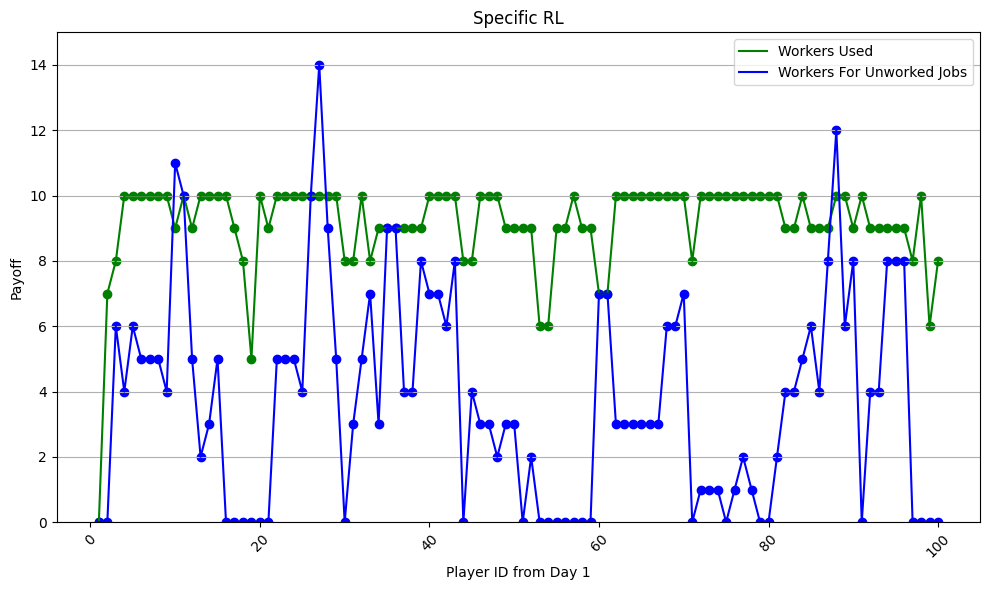

In [66]:
plt.figure(figsize=(10, 6))
plt.scatter(eff_1['Day'], eff_1['Workers Used'],  marker='o', color='green')
plt.plot(eff_1['Day'], eff_1['Workers Used'], label='Workers Used', color='green')
plt.scatter(eff_1['Day'], eff_1['Waiting Workers'], marker='o',color='blue')
plt.plot(eff_1['Day'], eff_1['Waiting Workers'], label='Workers For Unworked Jobs', color='blue')

plt.xlabel('Player ID from Day 1')
plt.ylabel('Payoff')
plt.ylim(0,15)
plt.title('Specific RL')
plt.legend()
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

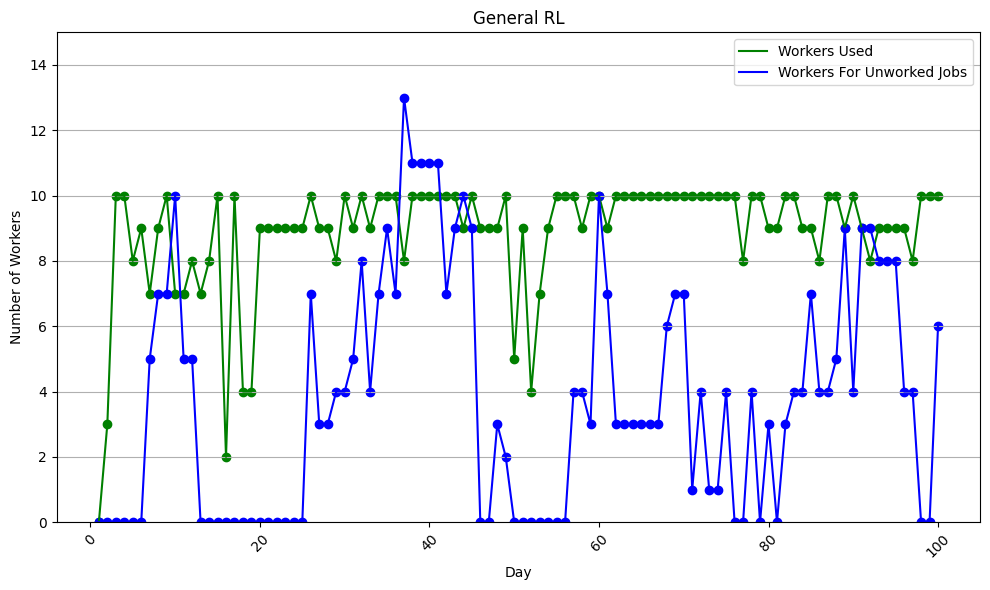

In [67]:
plt.figure(figsize=(10, 6))
plt.scatter(eff_2['Day'], eff_2['Workers Used'],  marker='o', color='green')
plt.plot(eff_2['Day'], eff_2['Workers Used'], label='Workers Used', color='green')
plt.scatter(eff_2['Day'], eff_2['Waiting Workers'], marker='o',color='blue')
plt.plot(eff_2['Day'], eff_2['Waiting Workers'], label='Workers For Unworked Jobs', color='blue')

plt.xlabel('Day')
plt.ylabel('Number of Workers')
plt.ylim(0,15)
plt.title('General RL')
plt.legend()
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

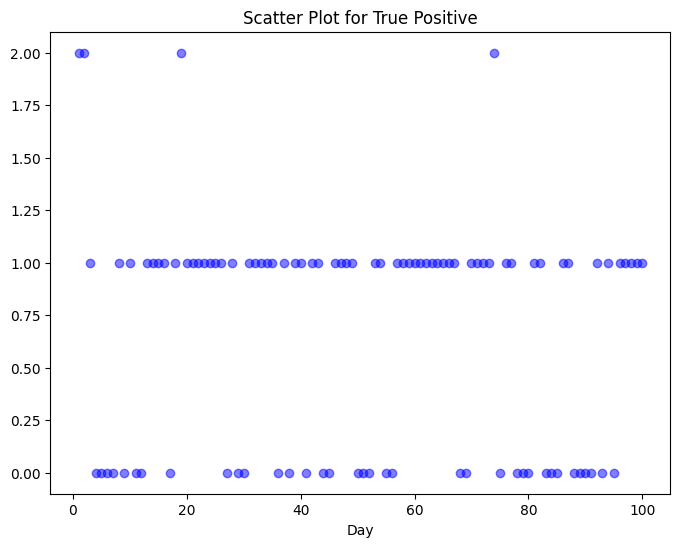

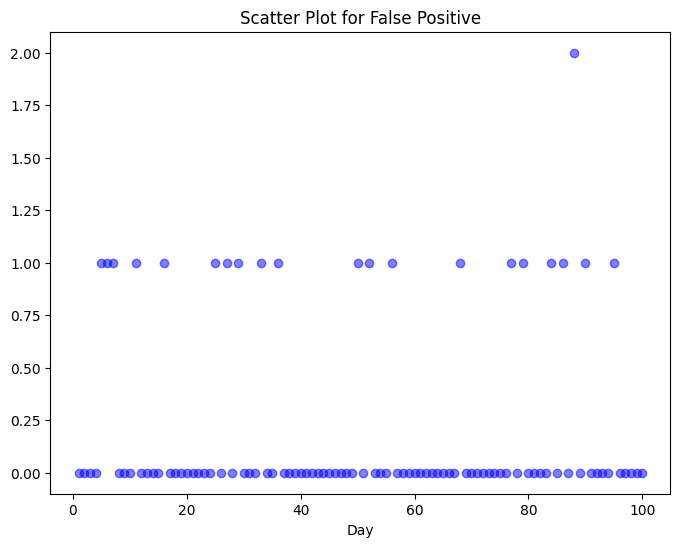

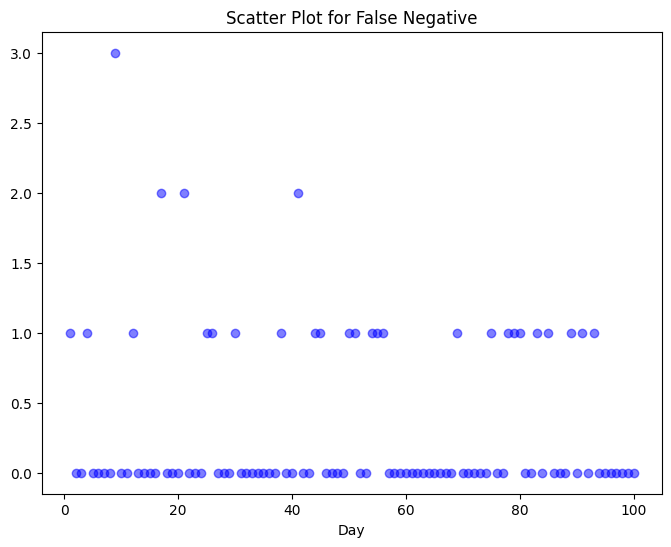

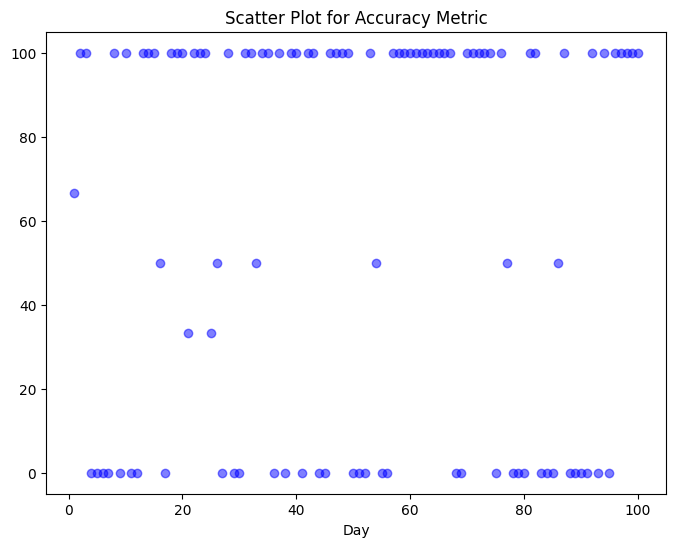

In [70]:
titles=['True Positive','False Positive','False Negative','Accuracy Metric']
for i in range(len(results)):
    data=results[i]
    # Create a scatter plot for each group
    plt.figure(figsize=(8, 6))
    
    # Plot 'Optimal' against 'session_id'
    plt.scatter(range(1,101), data, alpha=0.5, label=titles[i], color='blue', marker='o')
    
    
    # Plot 'Participant_earnings' against 'session_id'
    
    # Set plot title and labels
    plt.title(f'Scatter Plot for {titles[i]}')
    plt.xlabel('Day')

    # Save the plot or display it
    plt.show()

In [71]:
def count_occurrences(numbers):
    # Count the occurrences of each number
    counts = pd.Series(numbers).value_counts().reset_index()
    
    # Rename columns for clarity
    counts.columns = ['Number', 'Occurrences']
    
    # Sort the table by 'Number' in ascending order
    sorted_counts = counts.sort_values(by='Number').reset_index(drop=True)
    
    return sorted_counts
metric_df=count_occurrences(results[3])
metric_df

,Number,Occurrences
0,0.000000,36
1,33.333333,2
2,50.000000,6
3,66.666667,1
4,100.000000,55


In [72]:
t_positive_df=count_occurrences(results[0])
t_positive_df

,Number,Occurrences
0,0,36
1,1,60
2,2,4


In [73]:
f_positive_df=count_occurrences(results[1])
f_positive_df

,Number,Occurrences
0,0,79
1,1,20
2,2,1


In [74]:
f_negative_df=count_occurrences(results[2])
f_negative_df

,Number,Occurrences
0,0,72
1,1,24
2,2,3
3,3,1
